# Title: Data Processing for Hurricane Impact Analysis

## Description
This script processes and cleans a dataset related to the economic and social impacts of hurricanes in the United States. It leverages the OpenCage Data API to obtain latitude and longitude data for various locations and implements caching to optimize API usage.

## Technical Overview
- **Asynchronous Requests**: Utilized aiohttp and asyncio to handle geocoding API calls concurrently, improving processing speed and efficiency.
- **OpenCage Data API**: Used to retrieve reliable geocoding data, translating location names into geographic coordinates.
- **Caching Mechanism**: Implemented a cache to store the results of previous API calls, reducing redundant requests and helping avoid API rate limits.
- **Nesting Asyncio**: Applied nest_asyncio to facilitate running asynchronous event loops in Jupyter Notebooks or similar environments.

## Resource References
- **OpenCage Data API**: [opencagedata.com](https://opencagedata.com/)
- **aiohttp** Documentation: [aiohttp.readthedocs.io](https://docs.aiohttp.org/en/stable/)
- **asyncio** Documentation: [docs.python.org/3/library/asyncio.html](https://docs.python.org/3/library/asyncio.html)
- **nest_asyncio**: [nest_asyncio GitHub Repository](https://github.com/erdewit/nest_asyncio)
- **Caching Strategies**: Information on Python caching strategies was sourced from various online articles and documentation.

## Code Overview
The script begins by importing necessary libraries, loading the initial dataset, and then processing the data to include latitude and longitude information using the OpenCage Data API. A caching mechanism is implemented to optimize API usage and improve efficiency.

In [40]:
import requests
import pandas as pd
import aiohttp
import asyncio
import nest_asyncio
import json
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
from config import api_key
from config import api_key, api_key2
from matplotlib.ticker import FuncFormatter

### This code is designed to improve the efficiency of the script by utilizing a cache. 
It attempts to load cached location data from the 'location_cache.json' file.
If the file is found, the cached data is loaded, which can reduce the need for redundant computations or API calls.
If the file is not found, an empty cache is initialized, allowing the script to proceed without interruption.

In [2]:
# Load cache from a file (at the start of your script)
try:
    with open('location_cache.json', 'r') as cache_file:
        location_cache = json.load(cache_file)
except FileNotFoundError:
    location_cache = {}

In [3]:
# Read the CSV file
emdat_data = "Resource/public_emdat_data.csv"
emdat_data_df = pd.read_csv(emdat_data)

emdat_data_df

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,Reconstruction Costs ('000 US$),"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,Entry Date,Last Update
0,2000-0643-MEX,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,Keith,MEX,...,NaN,NaN,NaN,NaN,1000.0,1769.0,56.514291,"[{""adm1_code"":2031,""adm1_name"":""Campeche""},{""a...",2005-12-16,2023-09-25
1,2000-0652-USA,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,Leslie,USA,...,NaN,NaN,NaN,NaN,219000.0,387513.0,56.514291,"[{""adm2_code"":29003,""adm2_name"":""Broward""},{""a...",2003-07-01,2023-09-25
2,2001-0242-USA,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,Allison,USA,...,NaN,NaN,3500000.0,6022907.0,6000000.0,10324983.0,58.111474,"[{""adm1_code"":3223,""adm1_name"":""Florida""},{""ad...",2006-10-11,2023-09-25
3,2001-0488-MEX,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,Dalila,MEX,...,NaN,NaN,NaN,NaN,NaN,NaN,58.111474,"[{""adm1_code"":2032,""adm1_name"":""Chiapas""},{""ad...",2003-07-01,2023-09-25
4,2001-0562-MEX,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,Juliette,MEX,...,NaN,NaN,150000.0,258125.0,400000.0,688332.0,58.111474,"[{""adm1_code"":2030,""adm1_name"":""Baja Californi...",2004-10-28,2023-09-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2023-0675-MEX,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,GLIDE:TC-2023-000209,Tropical storm 'Otis',MEX,...,NaN,NaN,4000000.0,4000000.0,12000000.0,12000000.0,100.000000,NaN,2023-10-30,2024-03-04
142,2024-0402-MEX,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical storm 'Alberto',MEX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-06-21,2024-06-24
143,2024-0422-CAN,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,GLIDE:TC-2024-000105,Hurricane 'Beryl',CAN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-07-16,2024-08-01
144,2024-0422-USA,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,GLIDE:TC-2024-000105,Hurricane 'Beryl',USA,...,NaN,NaN,NaN,NaN,4500000.0,NaN,NaN,NaN,2024-07-10,2024-08-01


In [4]:
# Remove unnecessary columns to create a cleaned DataFrame
columns_to_keep = ["Start Year", "Start Month", "Start Day", "End Year", "End Month", "End Day", 
                   "Location", "Total Deaths", "No. Affected", 
                   "Total Affected", "Insured Damage ('000 US$)", "Total Damage ('000 US$)", 
                   "Magnitude", "Magnitude Scale"]
cleaned_emdat_data_df = emdat_data_df[columns_to_keep]
cleaned_emdat_data_df

,Start Year,Start Month,Start Day,End Year,End Month,End Day,Location,Total Deaths,No. Affected,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$),Magnitude,Magnitude Scale
0,2000,9,29,2000,10,3,"Puebla, Campeche, Quintana Roo, Yucatan, Verac...",23.0,30000.0,30000.0,NaN,1000.0,150.0,Kph
1,2000,10,4,2000,10,4,"Miami-Dade, Monroe, Broward, Collier districts...",2.0,14418.0,17433.0,NaN,219000.0,NaN,Kph
2,2001,6,5,2001,6,17,"Texas, Mississippi, Louisiana, Florida, Pennsy...",41.0,102000.0,172000.0,3500000.0,6000000.0,NaN,Kph
3,2001,7,25,2001,7,25,"Guerrero, Chiapas provinces",NaN,100.0,100.0,NaN,NaN,NaN,Kph
4,2001,9,24,2001,10,2,Baja California Sur province,3.0,3000.0,3800.0,150000.0,400000.0,120.0,Kph
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2023,10,22,2023,10,25,Acapulco (central Guerrero State),104.0,988000.0,988000.0,4000000.0,12000000.0,270.0,Kph
142,2024,6,20,2024,6,22,"Nuevo Leon, Veracruz, Tamaulipas, Coahuila,",4.0,NaN,NaN,NaN,NaN,NaN,Kph
143,2024,7,12,2024,7,12,Nouvelle Ecosse,1.0,NaN,NaN,NaN,NaN,NaN,Kph
144,2024,7,8,2024,7,9,"Texas, Louisiana",8.0,207.0,207.0,NaN,4500000.0,130.0,Kph


In [5]:
# Drop rows with missing values in any column
yearly_emdat_data_df = cleaned_emdat_data_df.dropna()
yearly_emdat_data_df

,Start Year,Start Month,Start Day,End Year,End Month,End Day,Location,Total Deaths,No. Affected,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$),Magnitude,Magnitude Scale
4,2001,9,24,2001,10,2,Baja California Sur province,3.0,3000.0,3800.0,150000.0,400000.0,120.0,Kph
8,2002,9,20,2002,9,20,"Campeche, Quintana Roo, Yucatan provinces",13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph
10,2002,9,26,2002,9,27,"Louisiane, Mississippi, Alabama, Tennessee pro...",1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph
14,2003,9,18,2003,9,22,"North Carolina, Maryland, Virginia, West Virgi...",16.0,225000.0,225000.0,1685000.0,3370000.0,170.0,Kph
19,2004,8,13,2004,8,13,"Bay, Calhoun, Escambia, Franklin, Gadsden, Gul...",10.0,30000.0,30000.0,7600000.0,16000000.0,230.0,Kph
27,2005,8,29,2005,9,19,"Mobile, Bayou La Batre, Dauphin Island, Coden ...",1833.0,500000.0,500000.0,60000000.0,125000000.0,280.0,Kph
29,2005,9,23,2005,10,1,"Louisiana, Texas, Mississippi provinces",10.0,300000.0,300000.0,11300000.0,16000000.0,280.0,Kph
32,2005,10,24,2005,10,24,"Florida Keys, Naples areas (Collier district, ...",4.0,30000.0,30000.0,10350000.0,14300000.0,165.0,Kph
38,2007,8,21,2007,8,24,"Yucatan, Quintana Roo, Campeche, Veracruz, Hid...",9.0,140000.0,140000.0,475000.0,600000.0,265.0,Kph
47,2008,9,12,2008,9,16,"Galveston, Brazoria, Harris, Chambers, Jeffers...",82.0,200000.0,200000.0,15000000.0,30000000.0,200.0,Kph


In [6]:
# Save the updated DataFrame to a new CSV file
#yearly_emdat_data_df.to_csv("Resource/yearly_emdat_data.csv", index=False)
print("Process completed and file saved.")

Process completed and file saved.


### The data separates the locations for adding latitude and longitude information

The dataset is organized in a way that allows us to add latitude and longitude coordinates to each location. This step is necessary for accurate mapping and visualization.


In [7]:
# Split the locations into separate rows and reset index
emdat_data_map_df = yearly_emdat_data_df.assign(Location=yearly_emdat_data_df['Location'].str.split(',')).explode('Location').reset_index(drop=True)
emdat_data_map_df

,Start Year,Start Month,Start Day,End Year,End Month,End Day,Location,Total Deaths,No. Affected,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$),Magnitude,Magnitude Scale
0,2001,9,24,2001,10,2,Baja California Sur province,3.0,3000.0,3800.0,150000.0,400000.0,120.0,Kph
1,2002,9,20,2002,9,20,Campeche,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph
2,2002,9,20,2002,9,20,Quintana Roo,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph
3,2002,9,20,2002,9,20,Yucatan provinces,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph
4,2002,9,26,2002,9,27,Louisiane,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,2021,8,28,2021,9,2,Connecticut,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph
210,2021,8,28,2021,9,2,Virginia,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph
211,2021,8,28,2021,9,2,Pennsylvania,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph
212,2021,8,28,2021,9,2,Delaware,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph


In [8]:
# Drop rows with missing values in any column
drop_emdat_data_map_df = emdat_data_map_df.dropna()
drop_emdat_data_map_df

,Start Year,Start Month,Start Day,End Year,End Month,End Day,Location,Total Deaths,No. Affected,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$),Magnitude,Magnitude Scale
0,2001,9,24,2001,10,2,Baja California Sur province,3.0,3000.0,3800.0,150000.0,400000.0,120.0,Kph
1,2002,9,20,2002,9,20,Campeche,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph
2,2002,9,20,2002,9,20,Quintana Roo,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph
3,2002,9,20,2002,9,20,Yucatan provinces,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph
4,2002,9,26,2002,9,27,Louisiane,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,2021,8,28,2021,9,2,Connecticut,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph
210,2021,8,28,2021,9,2,Virginia,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph
211,2021,8,28,2021,9,2,Pennsylvania,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph
212,2021,8,28,2021,9,2,Delaware,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph


In [9]:
drop_emdat_data_map_df['Location'] = drop_emdat_data_map_df['Location'].astype(str).str.strip()
print(type(emdat_data_map_df['Location'].iloc[0]))

<class 'str'>


In [10]:
# Define a dictionary with the old names as keys and new names as values
name_changes = {
    'Baja California Sur province': 'Baja California Sur',
    'Coden areas (Mobile district': 'Coden',
    'Alabama province)': 'Alabama',
    'New Orleans city (Orleans district': 'New Orleans City',
    'Louisiana province)': 'Louisiana',
    'Slidell area (St. Tammany district': 'Slidell',
    'Louisiana province)': 'Louisiana',
    'St. Bernard district (Louisiana province)': 'St. Bernard District',
    'Gulfport cities (Harrison district': 'Gulfport Cities',
    'Mississippi province)': 'Mississippi',
    'Pascagoula city (Jackson district': 'Pascagoula City',
    'Mississippi province)': 'Mississippi',
    'Bay St. Louis cities (Hancock district': 'Bay St. Louis Cities',
    'Mississippi province)': 'Mississippi',
    'Naples areas (Collier district': 'Naples',
    'Florida province)': 'Florida',
    'Virginia provinces': 'Virginia',
    'Puerto Escondido city (Dist. Pochutla district': 'Puerto Escondido City',
    'Oaxaca province)': 'Oaxaca',
    'Cabo San Lucas city (Los Cabos area': 'Cabo San Lucas City',
    'Manzanillo district (Colima province)': 'Manzanillo',
    'Eastern Texas (Rockport': 'Rockport',
    'San Augustine)': 'San Augustine',
    'Southwestern Louisiana (Acadia': 'Acadia',
    'Sabine)': 'Sabine',
    'Acapulco (central Guerrero State)': 'Acapulco (Central Guerrero State)',
    'Michigan provinces': 'Michigan',
    'Virginia provinces': 'Virginia',
    'Tamaulipas provinces': 'Tamaulipas',
    'Yucatan provinces': 'Yucatan',
    'Tennessee provinces': 'Tennessee',
    'District of Columbia provinces': 'District of Columbia',
    'North Carolina provinces': 'North Carolina',
    'Florida provinces': 'Florida',
    'Mississippi provinces': 'Mississippi',
    'Puebla provinces': 'Puebla',
    'District of Columbia provinces': 'District of Columbia',
    'Louisiane': 'Louisiana',
    'Nuevo leon': 'Nuevo León',
    'Baja California Sur province)': 'Baja California Sur',
    'Jefferson districts (Texas province)': 'Jefferson',
    'Washington districts (Florida province)': 'Washington',
    'La Paz district': 'La Paz',
    'Corpus Chrsti': 'Corpus Christi',
    'Bay': 'Bay City',
}
# Replace the old names with the new names
drop_emdat_data_map_df['Location'] = drop_emdat_data_map_df['Location'].replace(name_changes)
drop_emdat_data_map_df.head(40)

,Start Year,Start Month,Start Day,End Year,End Month,End Day,Location,Total Deaths,No. Affected,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$),Magnitude,Magnitude Scale
0,2001,9,24,2001,10,2,Baja California Sur,3.0,3000.0,3800.0,150000.0,400000.0,120.0,Kph
1,2002,9,20,2002,9,20,Campeche,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph
2,2002,9,20,2002,9,20,Quintana Roo,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph
3,2002,9,20,2002,9,20,Yucatan,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph
4,2002,9,26,2002,9,27,Louisiana,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph
5,2002,9,26,2002,9,27,Mississippi,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph
6,2002,9,26,2002,9,27,Alabama,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph
7,2002,9,26,2002,9,27,Tennessee,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph
8,2003,9,18,2003,9,22,North Carolina,16.0,225000.0,225000.0,1685000.0,3370000.0,170.0,Kph
9,2003,9,18,2003,9,22,Maryland,16.0,225000.0,225000.0,1685000.0,3370000.0,170.0,Kph


In [11]:
# Split the locations into separate rows and reset index
emdat_data_map_df = drop_emdat_data_map_df.assign(Location=drop_emdat_data_map_df['Location'].str.split(';')).explode('Location').reset_index(drop=True)
emdat_data_map_df

,Start Year,Start Month,Start Day,End Year,End Month,End Day,Location,Total Deaths,No. Affected,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$),Magnitude,Magnitude Scale
0,2001,9,24,2001,10,2,Baja California Sur,3.0,3000.0,3800.0,150000.0,400000.0,120.0,Kph
1,2002,9,20,2002,9,20,Campeche,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph
2,2002,9,20,2002,9,20,Quintana Roo,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph
3,2002,9,20,2002,9,20,Yucatan,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph
4,2002,9,26,2002,9,27,Louisiana,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2021,8,28,2021,9,2,Connecticut,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph
212,2021,8,28,2021,9,2,Virginia,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph
213,2021,8,28,2021,9,2,Pennsylvania,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph
214,2021,8,28,2021,9,2,Delaware,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph


In [12]:
# Define a dictionary with the old names as keys and new names as values
emdat_data_map_df['Location'] = emdat_data_map_df['Location'].str.replace('Virginia Tidewater region', 'Tidewater')
emdat_data_map_df.head(20)

,Start Year,Start Month,Start Day,End Year,End Month,End Day,Location,Total Deaths,No. Affected,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$),Magnitude,Magnitude Scale
0,2001,9,24,2001,10,2,Baja California Sur,3.0,3000.0,3800.0,150000.0,400000.0,120.0,Kph
1,2002,9,20,2002,9,20,Campeche,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph
2,2002,9,20,2002,9,20,Quintana Roo,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph
3,2002,9,20,2002,9,20,Yucatan,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph
4,2002,9,26,2002,9,27,Louisiana,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph
5,2002,9,26,2002,9,27,Mississippi,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph
6,2002,9,26,2002,9,27,Alabama,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph
7,2002,9,26,2002,9,27,Tennessee,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph
8,2003,9,18,2003,9,22,North Carolina,16.0,225000.0,225000.0,1685000.0,3370000.0,170.0,Kph
9,2003,9,18,2003,9,22,Maryland,16.0,225000.0,225000.0,1685000.0,3370000.0,170.0,Kph


In [13]:
#emdat_data_map_df.to_csv("/Users/sanemini/Desktop/cleaned_map.csv", index=False)

### Using Asynchronous Functions with aiohttp and asyncio

In this section, we define asynchronous functions to efficiently retrieve latitude and longitude data for each location. Traditional synchronous requests could significantly slow down the processing time, especially with large datasets. By implementing asynchronous requests, we can handle multiple requests concurrently, making the process much faster.

**Why Asynchronous?**
- **Performance**: Asynchronous requests allow multiple operations to occur at the same time, which reduces the waiting time for each request.
- **Learning Resource**: We learned about asynchronous programming through online documentation and resources like [aiohttp Documentation](https://docs.aiohttp.org/en/stable/) and [asyncio Documentation](https://docs.python.org/3/library/asyncio.html). This technique was not covered in traditional coursework, but it has significantly improved the efficiency of data processing in this project.

```python

In [14]:
# Define the base URL for the API
url = "https://api.opencagedata.com/geocode/v1/json?"

# Asynchronous function to get latitude and longitude for a given location
async def get_lat_long(session, location):
    request_url = f"{url}q={location}&key={api_key}"
    async with session.get(request_url) as response:
        if response.status == 200:
            data = await response.json()
            if data['results']:
                lat = data['results'][0]['geometry']['lat']
                long = data['results'][0]['geometry']['lng']
                return lat, long
        return None, None

# Asynchronous function to handle multiple requests
async def fetch_all_locations(df):
    async with aiohttp.ClientSession() as session:
        tasks = []
        for idx, row in df.iterrows():
            task = asyncio.create_task(get_lat_long(session, row['Location']))  # Changed to create_task
            tasks.append(task)
        responses = await asyncio.gather(*tasks)
        return responses

In [15]:
# Create new columns for latitude and longitude if they don't exist
if 'Latitude' not in emdat_data_map_df.columns:
    emdat_data_map_df['Latitude'] = None
if 'Longitude' not in emdat_data_map_df.columns:
    emdat_data_map_df['Longitude'] = None

In [16]:
# Allow nested asyncio event loops (necessary for Jupyter Notebook)
nest_asyncio.apply()

In [17]:
# Run the asynchronous fetching
results = asyncio.run(fetch_all_locations(emdat_data_map_df))

# Assign results back to the DataFrame
for idx, (lat, long) in enumerate(results):
    emdat_data_map_df.at[idx, 'Latitude'] = lat
    emdat_data_map_df.at[idx, 'Longitude'] = long

emdat_data_map_df

,Start Year,Start Month,Start Day,End Year,End Month,End Day,Location,Total Deaths,No. Affected,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$),Magnitude,Magnitude Scale,Latitude,Longitude
0,2001,9,24,2001,10,2,Baja California Sur,3.0,3000.0,3800.0,150000.0,400000.0,120.0,Kph,25.581801,-111.570616
1,2002,9,20,2002,9,20,Campeche,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph,19.0,-90.5
2,2002,9,20,2002,9,20,Quintana Roo,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph,19.666667,-88.5
3,2002,9,20,2002,9,20,Yucatan,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph,20.684596,-88.875567
4,2002,9,26,2002,9,27,Louisiana,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph,30.870388,-92.007126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2021,8,28,2021,9,2,Connecticut,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph,41.65002,-72.734216
212,2021,8,28,2021,9,2,Virginia,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph,37.123224,-78.492772
213,2021,8,28,2021,9,2,Pennsylvania,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph,40.969989,-77.727883
214,2021,8,28,2021,9,2,Delaware,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph,38.692045,-75.401331


In [18]:
# Drop rows with missing values in any column
emdat_data_map = emdat_data_map_df.dropna()

emdat_data_map

,Start Year,Start Month,Start Day,End Year,End Month,End Day,Location,Total Deaths,No. Affected,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$),Magnitude,Magnitude Scale,Latitude,Longitude
0,2001,9,24,2001,10,2,Baja California Sur,3.0,3000.0,3800.0,150000.0,400000.0,120.0,Kph,25.581801,-111.570616
1,2002,9,20,2002,9,20,Campeche,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph,19.0,-90.5
2,2002,9,20,2002,9,20,Quintana Roo,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph,19.666667,-88.5
3,2002,9,20,2002,9,20,Yucatan,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph,20.684596,-88.875567
4,2002,9,26,2002,9,27,Louisiana,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph,30.870388,-92.007126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2021,8,28,2021,9,2,Connecticut,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph,41.65002,-72.734216
212,2021,8,28,2021,9,2,Virginia,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph,37.123224,-78.492772
213,2021,8,28,2021,9,2,Pennsylvania,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph,40.969989,-77.727883
214,2021,8,28,2021,9,2,Delaware,96.0,14000.0,14000.0,36000000.0,65000000.0,240.0,Kph,38.692045,-75.401331


In [19]:
# Save the updated DataFrame to a new CSV file
#emdat_data_map.to_csv("Resource/emdat_data_map.csv", index=False)

print("Process completed and file saved.")

Process completed and file saved.


## State information has been added to the data to observe interstate sociological influence.


In [20]:
# Asynchronous function to fetch the state from OpenCage API based on latitude and longitude
async def reverse_geocode_opencage(session, lat, lon, api_key):
    url = f"https://api.opencagedata.com/geocode/v1/json?q={lat}+{lon}&key={api_key}"
    async with session.get(url) as response:
        if response.status == 200:
            result = await response.json()
            if result['results']:
                state = result['results'][0]['components'].get('state', 'Unknown')
                return state
        return 'Unknown'

# Asynchronous function to handle multiple requests concurrently
async def fetch_all_states(df):
    async with aiohttp.ClientSession() as session:
        tasks = []
        for idx, row in df.iterrows():
            task = asyncio.create_task(reverse_geocode_opencage(session, row['Latitude'], row['Longitude'], api_key2))
            tasks.append(task)
        states = await asyncio.gather(*tasks)
        return states

# Main function to run the asynchronous tasks and update the DataFrame
async def main():
    states = await fetch_all_states(emdat_data_map)
    emdat_data_map.loc[:, 'State'] = states  

# Execute the async main function to fetch and add the 'State' column
await main()

# Display the updated DataFrame with the new 'State' column
emdat_data_map.head()

/var/folders/10/nrrfd9q128d9x2q1vyyb65wh0000gn/T/ipykernel_4658/3150741256.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emdat_data_map.loc[:, 'State'] = states  # Using .loc to avoid SettingWithCopyWarning


,Start Year,Start Month,Start Day,End Year,End Month,End Day,Location,Total Deaths,No. Affected,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$),Magnitude,Magnitude Scale,Latitude,Longitude,State
0,2001,9,24,2001,10,2,Baja California Sur,3.0,3000.0,3800.0,150000.0,400000.0,120.0,Kph,25.581801,-111.570616,Baja California Sur
1,2002,9,20,2002,9,20,Campeche,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph,19.0,-90.5,Campeche
2,2002,9,20,2002,9,20,Quintana Roo,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph,19.666667,-88.5,Quintana Roo
3,2002,9,20,2002,9,20,Yucatan,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph,20.684596,-88.875567,Yucatán
4,2002,9,26,2002,9,27,Louisiana,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph,30.870388,-92.007126,Louisiana


In [22]:
# Save the updated DataFrame to a new CSV file
emdat_data_map.to_csv("Resource/emdat_data_map.csv", index=False)

print("Process completed and file saved.")

Process completed and file saved.


## Analysis of Total Deaths from Hurricanes by Year

This analysis focuses on the total number of deaths caused by hurricanes each year. The data is grouped by year, and the total deaths are summed to visualize the trend over time. The resulting plot highlights the years with the highest death tolls, helping us understand the social impact of hurricanes across different time periods.

In [25]:
# Group the data by 'Start Year' and sum 'Total Deaths' to analyze deaths by year
deaths_by_year = yearly_emdat_data_df.groupby('Start Year')['Total Deaths'].sum()
deaths_by_year

Start Year
2001       3.0
2002      14.0
2003      16.0
2004      10.0
2005    1847.0
2007       9.0
2008      82.0
2010      12.0
2011      15.0
2012       7.0
2014       6.0
2015      14.0
2016       3.0
2017      88.0
2018      49.0
2019       5.0
2020      33.0
2021      96.0
2023     104.0
Name: Total Deaths, dtype: float64

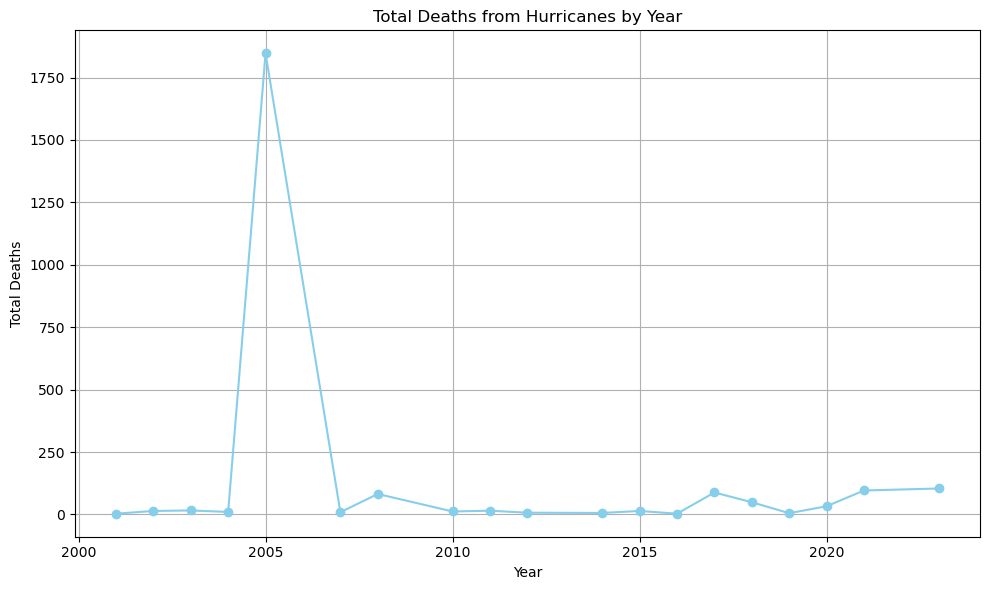

In [27]:
# Plot the total deaths by year
plt.figure(figsize=(10, 6))
plt.plot(deaths_by_year.index, deaths_by_year.values, marker='o', color='skyblue')
plt.title('Total Deaths from Hurricanes by Year')
plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.grid(True)
plt.tight_layout()
#plt.savefig('Images/Total_Deaths_by_Year.png')
plt.show()

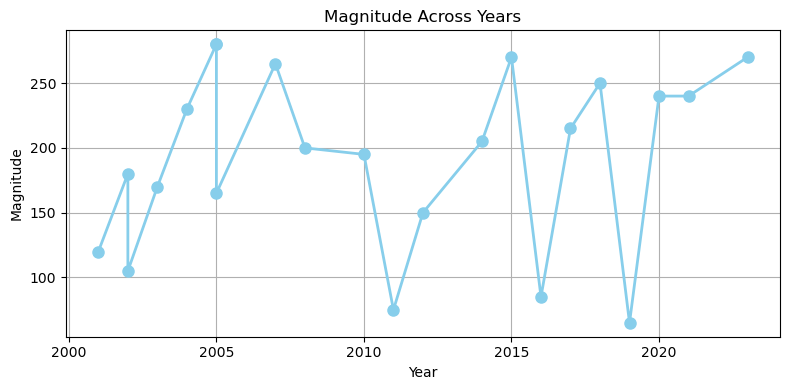

In [29]:
plt.figure(figsize=(8, 4))
plt.plot(yearly_emdat_data_df['Start Year'], yearly_emdat_data_df['Magnitude'], marker='o', color='skyblue', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Year')
plt.ylabel('Magnitude')
plt.title('Magnitude Across Years')
plt.tight_layout()
plt.grid(True)
#plt.savefig('Images/Magnitude_Across_Years.png')
plt.show()

## Analysis of Top 5 States from Hurricanes by Total Damages

This analysis examines the total damages caused by hurricanes in the top 5 most affected states. The data is aggregated by state, and the total damages are summed to identify the states that have suffered the most economic impact. The resulting plot showcases the states with the highest total damages, providing insights into the regional economic vulnerabilities to hurricanes.

In [33]:
# Aggregates yearly hurricane impact data, summing deaths, affected, damages, and taking max magnitude.
yearly_impact = emdat_data_map.groupby(['Start Year']).agg({
    'Total Deaths': 'sum',
    'Total Affected': 'sum',
    'Insured Damage (\'000 US$)': 'sum',
    'Total Damage (\'000 US$)': 'sum',
    'Magnitude': 'max'
}).reset_index()

yearly_cleaned = yearly_impact.rename(columns={'Start Year': 'Year'})
yearly_cleaned.head()

,Year,Total Deaths,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$),Magnitude
0,2001,3.0,3800.0,1.500000e+05,4.000000e+05,120.0
1,2002,43.0,1552890.0,1.640000e+06,3.120000e+06,180.0
2,2003,128.0,1800000.0,1.348000e+07,2.696000e+07,170.0
3,2004,200.0,600000.0,1.520000e+08,3.200000e+08,230.0
4,2005,33036.0,9990000.0,1.144950e+09,2.340900e+09,280.0


In [34]:
# Aggregates impact data by state, summing deaths, affected, and damages.
state_impact = emdat_data_map.groupby('State').agg({
    'Total Deaths': 'sum',
    'Total Affected': 'sum',
    'Insured Damage (\'000 US$)': 'sum',
    'Total Damage (\'000 US$)': 'sum'
}).reset_index()

state_impact.head()

,State,Total Deaths,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$)
0,Alabama,9328.0,3130824.0,348360000.0,753050000.0
1,Arkansas,115.0,206500.0,25000000.0,43000000.0
2,Auvergne-Rhône-Alpes,88.0,582024.0,30000000.0,95000000.0
3,Baja California Sur,9.0,78935.0,1350000.0,2900000.0
4,California,98.0,612024.0,37600000.0,111000000.0


In [37]:
# Sorts states by total damage and selects the top 5 most affected.
top_total_damage = state_impact.sort_values(by='Total Damage (\'000 US$)', ascending=False)
top_5_total_damage = top_total_damage.head(5)
top_5_total_damage

,State,Total Deaths,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$)
45,Texas,5549.0,34663468.0,1.853660e+09,5.694250e+09
24,Louisiana,8009.0,5444420.0,4.630600e+08,1.100050e+09
27,Mississippi,11331.0,5096372.0,4.796600e+08,1.081050e+09
0,Alabama,9328.0,3130824.0,3.483600e+08,7.530500e+08
16,Florida,2047.0,1369234.0,1.671100e+08,3.624000e+08


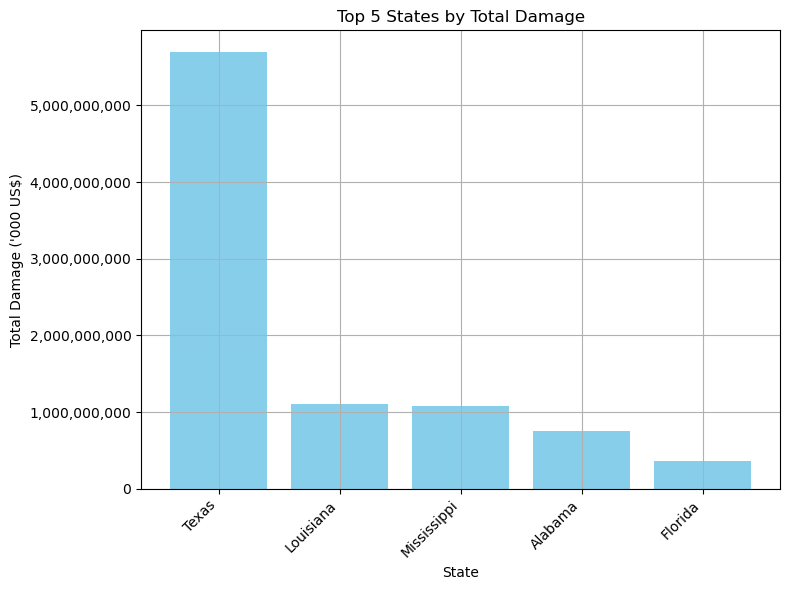

In [42]:
# Plotting the top 5 states by total damage
plt.figure(figsize=(8, 6)) 
ax = plt.gca() 
ax.bar(top_5_total_damage['State'], top_5_total_damage['Total Damage (\'000 US$)'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Total Damage (\'000 US$)')
plt.title('Top 5 States by Total Damage')
plt.xticks(rotation=45, ha='right')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))  
plt.grid(True)
plt.tight_layout()
#plt.savefig('Images/Top_5_States_by_Total_Damage.png')
plt.show()

In [44]:
top_total_deaths = state_impact.sort_values(by='Total Deaths', ascending=False)
top_5_total_deaths = top_total_deaths.head(5)
top_5_total_deaths

,State,Total Deaths,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$)
27,Mississippi,11331.0,5096372.0,4.796600e+08,1.081050e+09
0,Alabama,9328.0,3130824.0,3.483600e+08,7.530500e+08
24,Louisiana,8009.0,5444420.0,4.630600e+08,1.100050e+09
45,Texas,5549.0,34663468.0,1.853660e+09,5.694250e+09
16,Florida,2047.0,1369234.0,1.671100e+08,3.624000e+08


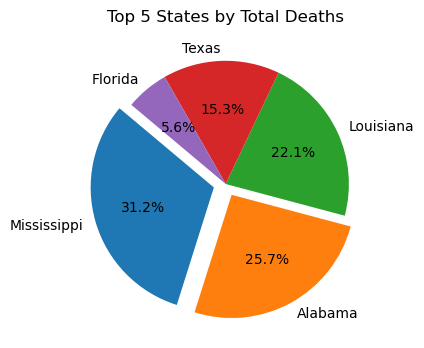

In [46]:
#Plotting a pie chart of the top 5 states by total deaths
plt.figure(figsize=(4, 4))
explode = [0.1, 0.1, 0, 0, 0]
plt.pie(
    top_5_total_deaths['Total Deaths'],
    labels=top_5_total_deaths['State'],
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.get_cmap('tab10').colors,
    explode=explode
)
plt.title('Top 5 States by Total Deaths')
#plt.savefig('Images/Top_5_States_by_Total_Deaths.png')
plt.show()

### Identifying and plotting the top 5 states by total number of affected persons
The data is sorted by 'Total Affected' to find the states with the highest number of individuals impacted by hurricanes.
A bar chart is then plotted to visualize these top 5 states, highlighting the most affected regions.


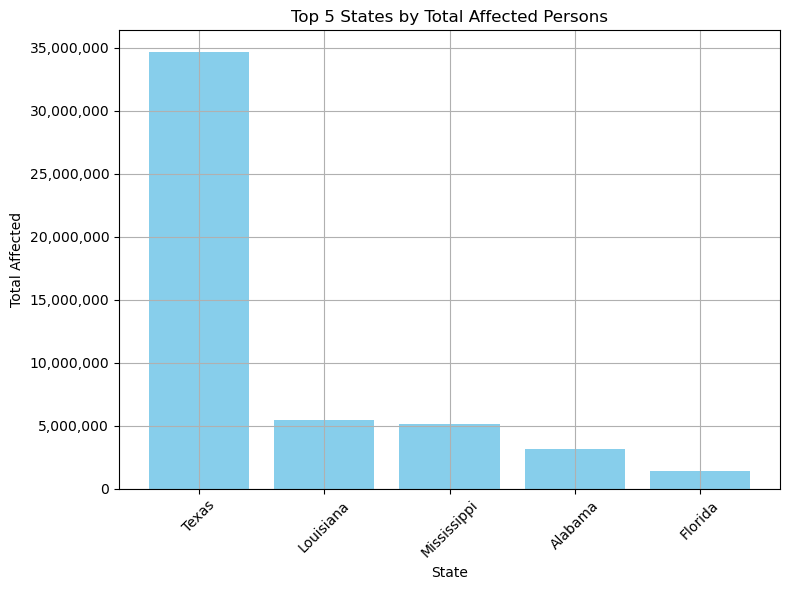

In [49]:
# Plotting the top 5 states by total affected persons
top_total_affected = state_impact.sort_values(by='Total Affected', ascending=False)
top_5_total_affected = top_total_affected.head(5)

plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.bar(top_5_total_affected['State'], top_5_total_affected['Total Affected'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Total Affected')
plt.title('Top 5 States by Total Affected Persons')
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))  
plt.grid(True)
plt.tight_layout()
#plt.savefig('Images/Top_5_States_by_Total_Affected_Persons.png')
plt.show()

### Correlation Analysis of Key Variables

This code calculates the correlation matrix for key variables related to hurricanes, such as Magnitude, Insured Damage, Total Damage, Total Deaths, and Total Affected. The correlation matrix helps in understanding the relationships between these variables, providing insights into how they are interconnected.


In [51]:
# Calculating the correlation matrix for key variables
correlation_matrix = emdat_data_map[['Magnitude', 'Insured Damage (\'000 US$)', 'Total Damage (\'000 US$)', 'Total Deaths', 'Total Affected']].corr()
correlation_matrix

,Magnitude,Insured Damage ('000 US$),Total Damage ('000 US$),Total Deaths,Total Affected
Magnitude,1.000000,0.567450,0.482778,0.438306,0.361203
Insured Damage ('000 US$),0.567450,1.000000,0.942744,0.736946,0.679521
Total Damage ('000 US$),0.482778,0.942744,1.000000,0.531273,0.842896
Total Deaths,0.438306,0.736946,0.531273,1.000000,0.275169
Total Affected,0.361203,0.679521,0.842896,0.275169,1.000000


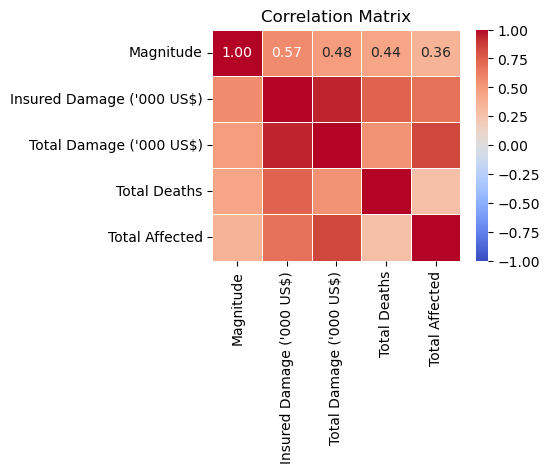

In [64]:
# Plotting the correlation matrix heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
#plt.savefig('Images/Correlation_Matrix.png')
plt.show()

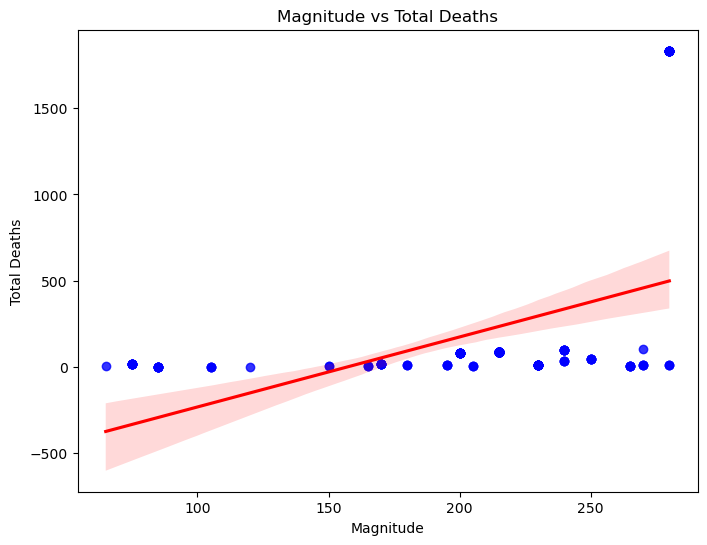

In [66]:
# Plotting the regression of Magnitude vs Total Deaths
plt.figure(figsize=(8, 6))
sns.regplot(data=emdat_data_map, x='Magnitude', y='Total Deaths', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Magnitude vs Total Deaths')
plt.xlabel('Magnitude')
plt.ylabel('Total Deaths')
#plt.savefig('Images/Total_Deaths.png')
plt.show()

# Yearly Total Economic Damage Analysis
This section analyzes the total economic damage caused by hurricanes over the years.

In [67]:
# Extract the necessary columns for the analysis
yearly_damage_data = yearly_emdat_data_df[['Start Year', 'Total Damage (\'000 US$)']]
# Sum the total damages by year
yearly_total_damage = yearly_damage_data.groupby('Start Year').sum()
yearly_total_damage

,Total Damage ('000 US$)
Start Year,
2001,400000.0
2002,940000.0
2003,3370000.0
2004,16000000.0
2005,155300000.0
2007,600000.0
2008,30000000.0
2010,3900000.0
2011,750000.0


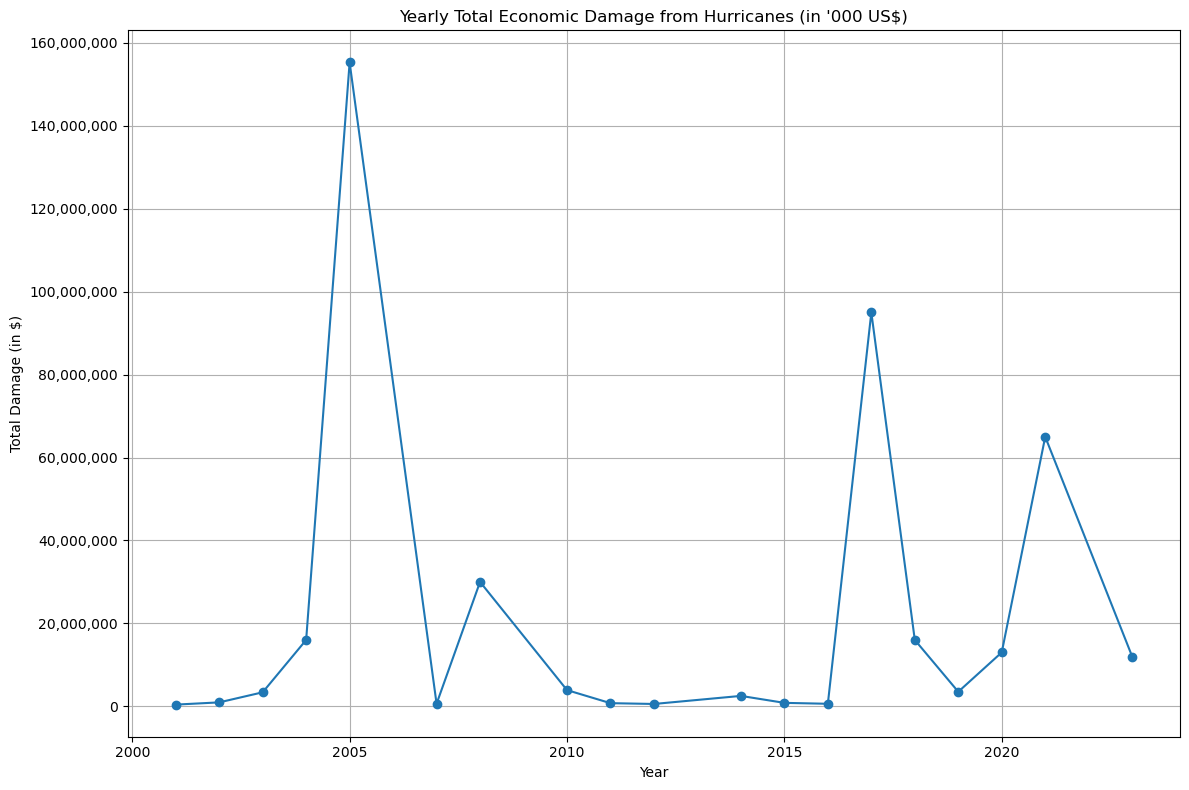

In [57]:
# Plot the yearly total economic damage
plt.figure(figsize=(12, 8))
ax = plt.plot(yearly_total_damage.index, yearly_total_damage['Total Damage (\'000 US$)'], marker='o')
plt.title('Yearly Total Economic Damage from Hurricanes (in \'000 US$)')
plt.xlabel('Year')
plt.ylabel('Total Damage (in $)') 
plt.grid(True) 
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
plt.tight_layout() 
#plt.savefig('Images/Yearly_Total_Economic_Damage.png')
plt.show() 

In [68]:
# Extract the necessary columns for the analysis
yearly_Insured_data = yearly_emdat_data_df[['Start Year', 'Insured Damage (\'000 US$)']]
# Sum the total damages by year
yearly_Insured_data = yearly_Insured_data.groupby('Start Year').sum()
yearly_Insured_data

,Insured Damage ('000 US$)
Start Year,
2001,150000.0
2002,480000.0
2003,1685000.0
2004,7600000.0
2005,81650000.0
2007,475000.0
2008,15000000.0
2010,150000.0
2011,560000.0


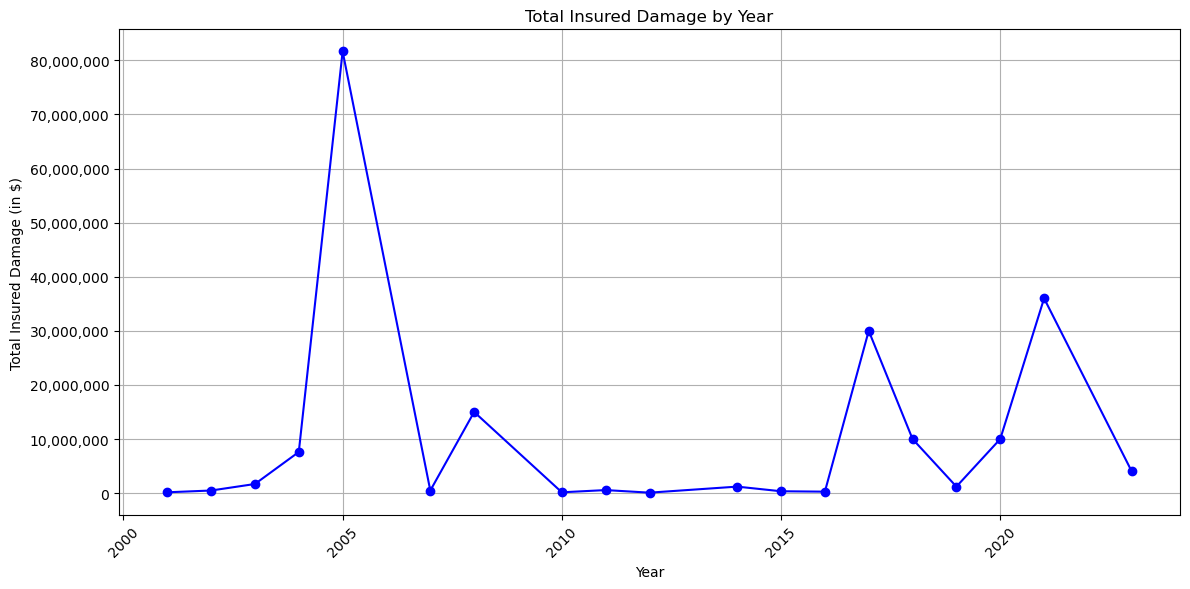

In [69]:
# Visualization of Insured Damage by Year
# Visualization of Insured Damage by Year
plt.figure(figsize=(12, 6))
plt.plot(yearly_Insured_data.index, yearly_Insured_data['Insured Damage (\'000 US$)'], marker='o', color='blue')
plt.title('Total Insured Damage by Year')
plt.xlabel('Year')
plt.ylabel('Total Insured Damage (in $)')
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
#plt.savefig('Images/Yearly_Total_Insured_Damage.png')
plt.show()